# Q1 Model Selection
    by Jacob Williams
    id 260400597
    email jacob.williams@mail.mcgill.ca
    for Applied Machine Learning - COMP 552
   

## 1. Fitting 20-degree polynomial
First step is reading in the data and creating an input x matrix and Y matrix

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import pylab
from numpy.linalg import inv

TrnDf = pd.read_csv('Data\Dataset_1_train.csv',header=None, index_col=False)
VldDf = pd.read_csv('Data\Dataset_1_valid.csv',header=None, index_col=False)
TstDf = pd.read_csv('Data\Dataset_1_test.csv',header=None, index_col=False)

TrnDf = TrnDf.as_matrix()
VldDf = VldDf.as_matrix()
TstDf = TstDf.as_matrix()

Ytrn = TrnDf[:,1]
Yvld = VldDf[:,1]
Ytst = TstDf[:,1]

Xtrn = TrnDf[:,0]
Xvld = VldDf[:,0]
Xtst = TstDf[:,0]

#This equation will take a 1d input array, and will create a new
# array for a n-degree polynomial fit
def nDegExpansion(X, n):
    numrows = len(X)
    X_n = np.zeros((numrows, n+1)) #add 1 for constant term
    for r in range(numrows):
        for i in range(n+1): #add 1 for constant term
            X_n[r,i] = X[r,]**i
    return X_n

X_n_trn = nDegExpansion(Xtrn, 20)
X_n_vld = nDegExpansion(Xvld, 20)

### Fitting the model
Now that all of the input matrixes have been made we will calculate the weight matrix
W=(XT*X)^-1*XT*Y
Next we will calculate the predicted Y matrix
Yp=X*W

In [3]:
#takes input x, y, and empty weight matrix and fills in the W matrix
#also prints out the predicted Y and W to csv files
def fitModel(X, Y):
    prt1 = inv(np.dot(X.transpose(), X))
    prt2 = np.dot(prt1, X.transpose())
    W = np.dot(prt2, Y)
    return W

#equation to calculate MSE error
def errMSE(X, Y, W):
    prt1 = np.subtract(Y, np.dot(X,W))
    return np.dot(prt1.transpose(),prt1)

W = fitModel(X_n_trn, Ytrn)

print("Training MSE : " , errMSE(X_n_trn, Ytrn, W))
print("Validation MSE : " , errMSE(X_n_vld, Yvld, W))

Validation MSE :  323.737802642
Training MSE :  71134.6427935


### Visualizing the fit
Next we have to set up methods for plotting a linear model with it's data points

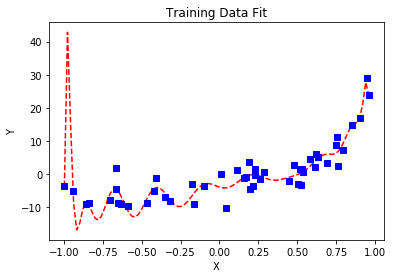

In [3]:
#linear model will take an x position, and a weight matrix
# output an expected y value
#assisted by following stack overflow post
#https://stackoverflow.com/questions/14000595/graphing-an-equation-with-matplotlib
def linmdl(x, W):
    y=0
    for i in range(len(W)):
        y+=(x**i)*W[i]
    return y

#function to plot constructed linear model line, and data points
def plotLmPts(Xpts, Ypts, W, Title):
    minX = np.min(Xpts)
    maxX = np.amax(Xpts)
    
    Xlm = np.linspace(minX, maxX, 100)
    Ylm = np.zeros((Xlm.shape))
 
    for i in range(len(Xlm)):
        Ylm[i,] = linmdl(Xlm[i,], W)
    
    plt.plot(Xlm, Ylm,'r--', Xpts, Ypts, 'bs')
    plt.title(Title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

plotLmPts(Xtrn, Ytrn, W, "Training Data Fit")

## 2.  L2 Regularization

In [4]:
def fitModelL2(X, Y, lmda):
    prt1 = np.dot(X.transpose(),X)
    prt2 = np.multiply(np.identity(prt1.shape[0]), lmda)
    prt3 = inv(np.add(prt1,prt2))
    prt4 = np.dot(prt3,X.transpose())
    W = np.dot(prt4, Y)
    return W

#equation for to calculate the derivative of MSE error
def d_errMSE(X, Y, W):
    prt1 = np.dot(np.dot(X.transpose(),X),W)
    prt2 = np.dot(X.transpose(),Y)
    return np.multiply(2,np.subtract(prt1,prt2))

#equation to calculate L2 error
def errL2(X, Y, W, lmda):
    prt1 = np.subtract(Y, np.dot(X,W))
    prt2 = np.dot(prt1.transpose(),prt1)
    prt3 = np.multiply(np.dot(W.transpose(),W), lmda)
    return np.add(prt2, prt3)

#for visualizing a broad spectrum of lambda values to see it's effect
lmda = .0
step = .1
stop = 1 #inclusive stop
numsteps = int(stop/step+1)
lmdLst = np.zeros((numsteps,))
vldMSE = np.zeros((numsteps,))
trnMSE = np.zeros((numsteps,))


### Visualizing the Mean Squared Error 

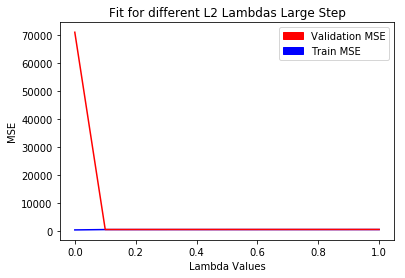

In [5]:
for i in range(numsteps):
    lmdLst[i,] = lmda
    
    W = fitModelL2(X_n_trn, Ytrn, lmda)
    trnMSE[i,] = errMSE(X_n_trn, Ytrn, W)
    
    X_n_vld = nDegExpansion(Xvld, 20)
    vldMSE[i,] = errMSE(X_n_vld, Yvld, W)
        
    lmda += step
    
plt.title('Fit for different L2 Lambdas Large Step') 
plt.xlabel('Lambda Values')
plt.ylabel('MSE')
plt.plot(lmdLst, trnMSE, 'b', lmdLst, vldMSE, 'r')

#creating legend
red_patch = mpatches.Patch(color='red', label='Validation MSE')
blue_patch = mpatches.Patch(color='blue', label = 'Train MSE')
plt.legend(handles=[red_patch, blue_patch])


plt.show()

Do not get a good sense of the behavior of lambda for smaller values beyond the fact at zero it will be much higher.  So we cut off a set of the smaller lambda values, knowing that the associated MSE is much higher on the validation set due to overfitting.

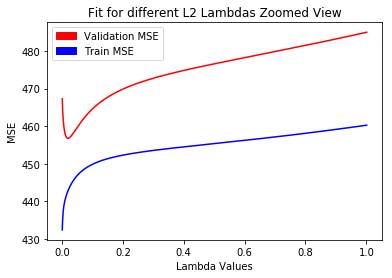

In [6]:
#for visualizing a more narrow selection of the 
lmda = 0.001
step = .001
stop = 1 #inclusive stop
numsteps = int(stop/step+1)
lmdLst = np.zeros((numsteps,))
vldMSE = np.zeros((numsteps,))
trnMSE = np.zeros((numsteps,))

for i in range(numsteps):
    lmdLst[i,] = lmda
    
    W = fitModelL2(X_n_trn, Ytrn, lmda)
    trnMSE[i,] = errMSE(X_n_trn, Ytrn, W)
    
    X_n_vld = nDegExpansion(Xvld, 20)
    vldMSE[i,] = errMSE(X_n_vld, Yvld, W)
        
    lmda += step

plt.title('Fit for different L2 Lambdas Zoomed View') 
plt.xlabel('Lambda Values')
plt.ylabel('MSE')
plt.plot(lmdLst, trnMSE, 'b', lmdLst, vldMSE, 'r')

#creating legend
red_patch = mpatches.Patch(color='red', label='Validation MSE')
blue_patch = mpatches.Patch(color='blue', label = 'Train MSE')
plt.legend(handles=[red_patch, blue_patch])

plt.show()

### Visualizing the best fit value of Lambda

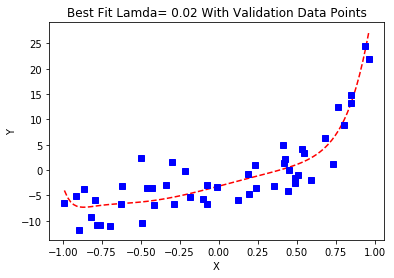

In [7]:
lmda = lmdLst[vldMSE.argmin(axis=0),]

W = fitModelL2(X_n_trn, Ytrn, lmda)

title = "Best Fit Lamda= " +str(lmda) + " With Validation Data Points"

plotLmPts(Xtst, Ytst, W, title)